Decison Tree and MLP for Nighttime PM2.5 Prediction by Photographic Measurement

In [1]:
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

import scipy.io as sio
from scipy import stats
from scipy import ndimage
from scipy.interpolate import griddata
import math
import random

import time
import datetime
from datetime import date
from datetime import timedelta
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, DateFormatter
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
from mpl_toolkits.basemap import Basemap

import xlrd 
import xlwt 
import xlsxwriter
import pathlib
from pathlib import Path

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})

matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
#matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Times New Roman'] 
#plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False 

def get_filename(filename):
  (filepath,tempfilename) = os.path.split(filename);
  (shotname,extension) = os.path.splitext(tempfilename);
  #return filepath, shotname, extension
  return shotname

def Normaltime(str_time_input):
    Normaltime_output = datetime.strptime(str_time_input,'%Y-%m-%d %H_%M')
    return Normaltime_output

def Changestr(datetime_input):
    str_output = datetime_input.strftime('%Y-%m-%d %H:%M')
    return str_output

def TS(x):
    return (x - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
    #return datetime.utcfromtimestamp(x.astype('O')/1e9)
    #return datetime.fromtimestamp(x.tolist()/1e9)

def DT(x):
    return datetime.utcfromtimestamp(x)

def quantile_clip(group):
    group.plot()
    group[group < group.quantile(.02)] = group.quantile(.02)
    group[group > group.quantile(.98)] = group.quantile(.98)
    #group.plot()
    #plt.show()
    return group

def flat(nums):
    res = []
    for i in nums:
        if isinstance(i, list):
            res.extend(flat(i))
        else:
            res.append(i)
    return res

def excel_to_df(xlsx):
    df=pd.DataFrame(pd.read_excel(xlsx, sheet_name=get_filename(xlsx)))
    return df

In [3]:
file_Lidar_AQI_Met = 'Lidar_AQI_Met.xlsx'
file_PhotoRGB_AQI_Met = 'PhotoRGB_AQI_Met.xlsx'

Lidar_AQI_Met = excel_to_df(file_Lidar_AQI_Met)
PhotoRGB_AQI_Met=excel_to_df(file_PhotoRGB_AQI_Met)

In [4]:
Lidar_AQI_Met.head(10)

,Time,60m,120m,210m,510m,1020m,1500m,2010m,3000m,5010m,...,T_700,RH_700,U_700,V_700,GP_700,T_850,RH_850,U_850,V_850,GP_850
0,2017-01-01 00:00:00,0.998039,0.996078,0.000000,0.0,0.0,0.0,0.0,0.0,0.050980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 01:00:00,0.750000,0.996078,0.000000,0.0,0.0,0.0,0.0,0.0,0.050000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01 02:00:00,0.750000,0.996078,0.000000,0.0,0.0,0.0,0.0,0.0,0.039216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 03:00:00,1.000000,0.996078,0.000000,0.0,0.0,0.0,0.0,0.0,0.032353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 04:00:00,1.000000,0.996078,0.000000,0.0,0.0,0.0,0.0,0.0,0.016667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2017-01-01 05:00:00,1.000000,0.996078,0.000000,0.0,0.0,0.0,0.0,0.0,0.014706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2017-01-01 06:00:00,0.750000,0.996078,0.000000,0.0,0.0,0.0,0.0,0.0,0.003922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2017-01-01 07:00:00,1.000000,0.498039,0.000000,0.0,0.0,0.0,0.0,0.0,0.002941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2017-01-01 08:00:00,1.000000,0.498039,0.000000,0.0,0.0,0.0,0.0,0.0,0.001961,...,-8.077401,11.150547,13.847446,1.489179,29880.113023,0.643871,29.074803,6.785103,-0.520943,14860.405353
9,2017-01-01 09:00:00,0.750000,0.997059,0.498039,0.0,0.0,0.0,0.0,0.0,0.022549,...,-8.222550,13.189051,14.749292,1.845663,29930.166625,0.626371,27.756528,6.863432,-1.089781,14909.733540


In [5]:
PhotoRGB_AQI_Met.tail(10)

,Time,R_R_M,G_R_M,B_R_M,R_L_M,G_L_M,B_L_M,PM2.5,PM10,SO2,...,T_700,RH_700,U_700,V_700,GP_700,T_850,RH_850,U_850,V_850,GP_850
6672,2020-03-03 00:00:00,14.151749,7.549884,4.846153,13.109260,13.510171,14.350148,50.0,33.0,3.0,...,-15.652557,71.490104,10.727301,1.807684,29111.299219,-5.261732,62.496520,7.592054,-9.057551,14462.292835
6673,2020-03-03 01:00:00,8.262317,4.964623,3.016520,9.744970,10.836209,12.570807,59.0,42.0,3.0,...,-16.255152,62.800534,11.520667,0.606623,29084.732287,-5.574548,38.068176,7.839909,-11.098263,14461.407271
6674,2020-03-03 02:00:00,4.932580,4.031668,1.784300,11.101873,10.373760,10.848863,60.0,40.0,3.0,...,-16.593429,45.388586,12.607059,0.151312,29042.225196,-6.035284,31.290180,8.818588,-11.125560,14442.810419
6675,2020-03-03 03:00:00,2.640645,4.012834,1.262349,6.981145,7.192411,7.021112,59.0,38.0,3.0,...,-16.664965,23.538900,13.773366,-0.893612,29012.116006,-6.879160,34.680271,9.606163,-11.844012,14441.924854
6676,2020-03-03 04:00:00,2.852172,3.999403,1.334869,9.580993,8.221080,7.288990,19.0,13.0,1.0,...,-17.088115,14.355032,13.717772,-4.292614,28927.987388,-7.567840,38.848991,10.504926,-12.796126,14387.905425
6677,2020-03-03 05:00:00,3.601720,3.976215,4.355814,9.890073,8.451694,8.066061,5.0,19.0,1.0,...,-17.730721,16.093821,12.740252,-7.045228,28908.504971,-8.241971,40.874297,10.333513,-14.433937,14388.790990
6678,2020-03-03 06:00:00,192.657215,205.233848,199.139229,58.996045,53.497840,49.829146,6.0,27.0,1.0,...,-18.106586,18.998364,11.511402,-8.799869,28904.962713,-8.449302,46.226267,7.728722,-13.099667,14400.303327
6679,2020-03-03 07:00:00,180.849761,204.627872,206.672048,105.765903,92.520492,71.519379,9.0,40.0,2.0,...,-18.047175,23.565145,10.709928,-8.960374,28942.156418,-8.845778,45.983493,6.109559,-14.508184,14457.865013
6680,2020-03-03 08:00:00,158.286751,188.749436,200.155608,133.865688,120.273148,92.558180,9.0,40.0,2.0,...,-18.188153,27.316194,9.730077,-9.203631,28990.714681,-8.809811,42.404825,3.365809,-15.879257,14521.891038
6681,2020-03-03 09:00:00,149.166447,183.679463,196.686148,149.023774,136.469500,104.698705,10.0,41.0,2.0,...,-18.622559,33.567448,7.696288,-9.156200,29022.392951,-8.772403,40.412811,1.417684,-16.778239,14564.430430


In [6]:
print(Lidar_AQI_Met.columns.values.tolist())
print('')
print(PhotoRGB_AQI_Met.columns.values.tolist())

['Time', '60m', '120m', '210m', '510m', '1020m', '1500m', '2010m', '3000m', '5010m', 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO', 'T2m', 'BLH', 'U10', 'V10', 'TP', 'SP', 'T_500', 'RH_500', 'U_500', 'V_500', 'GP_500', 'T_700', 'RH_700', 'U_700', 'V_700', 'GP_700', 'T_850', 'RH_850', 'U_850', 'V_850', 'GP_850']

['Time', 'R_R_M', 'G_R_M', 'B_R_M', 'R_L_M', 'G_L_M', 'B_L_M', 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO', 'T2m', 'BLH', 'U10', 'V10', 'TP', 'SP', 'T_500', 'RH_500', 'U_500', 'V_500', 'GP_500', 'T_700', 'RH_700', 'U_700', 'V_700', 'GP_700', 'T_850', 'RH_850', 'U_850', 'V_850', 'GP_850']


In [7]:
Va_Lidar=['60m', '120m', '210m', '510m', '1020m', '1500m', '2010m', '3000m', '5010m']
Va_Phtoto=['R_R_M', 'G_R_M', 'B_R_M', 'R_L_M', 'G_L_M', 'B_L_M']

Va_AQI=[ 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO']

Va_Met_Ground=['T2m', 'BLH', 'U10', 'V10', 'TP', 'SP']
Va_Met_Levels=['T_500', 'U_500', 'V_500', 'T_700', 'U_700', 'V_700','T_850', 'U_850', 'V_850']

Va_GE=['GE_500','KE_850']

In [8]:
dfs=[Lidar_AQI_Met,PhotoRGB_AQI_Met]

for df in dfs:
    T_500=df['T_500']
    T_850=df['T_850']
    Ro_500=T_500.map(lambda x: 50000*29/(8314*(x+273.15)))
    Ro_850=T_850.map(lambda x: 85000*29/(8314*(x+273.15)))

    U_500=df['U_500']
    V_500=df['V_500']
    U_850=df['U_850']
    V_850=df['V_850']

    KE_500=0.5*Ro_500*(U_500**2+V_500**2)
    KE_850=0.5*Ro_850*(U_850**2+V_850**2)

    GP_500=df['GP_500']
    GP_850=df['GP_850']
    GE_500=Ro_500*GP_500
    GE_850=Ro_850*GP_850

    df['GE_500']=GE_500
    df['KE_500']=KE_500
    df['GE_850']=GE_850
    df['KE_850']=KE_850

In [9]:
dfs[0].tail()

,Time,60m,120m,210m,510m,1020m,1500m,2010m,3000m,5010m,...,GP_700,T_850,RH_850,U_850,V_850,GP_850,GE_500,KE_500,GE_850,KE_850
8755,2017-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29025.124044,-7.423058,27.592111,6.786082,-3.364465,14524.655993,38239.972461,214.847626,16206.049802,32.005909
8756,2017-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29103.276603,-7.312177,27.265412,6.154220,-2.610035,14592.247395,38309.959973,220.975169,16274.674645,24.919450
8757,2017-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29150.449769,-7.313176,26.720914,5.045139,-2.085801,14635.196099,38353.150002,233.833146,16322.636496,16.620197
8758,2017-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29165.939466,-7.420061,27.056688,4.177687,-1.120059,14653.502104,38369.473790,252.809970,16349.626926,10.436493
8759,2017-12-31 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29206.775938,-7.487989,27.476405,3.778998,-0.084180,14697.858961,38403.059488,272.169364,16403.311143,7.972899


In [10]:
dfs[1].tail()

,Time,R_R_M,G_R_M,B_R_M,R_L_M,G_L_M,B_L_M,PM2.5,PM10,SO2,...,GP_700,T_850,RH_850,U_850,V_850,GP_850,GE_500,KE_500,GE_850,KE_850
6677,2020-03-03 05:00:00,3.601720,3.976215,4.355814,9.890073,8.451694,8.066061,5.0,19.0,1.0,...,28908.504971,-8.241971,40.874297,10.333513,-14.433937,14388.790990,37740.229281,403.266279,16104.086166,176.342820
6678,2020-03-03 06:00:00,192.657215,205.233848,199.139229,58.996045,53.497840,49.829146,6.0,27.0,1.0,...,28904.962713,-8.449302,46.226267,7.728722,-13.099667,14400.303327,37843.871764,397.569418,16129.594798,129.557357
6679,2020-03-03 07:00:00,180.849761,204.627872,206.672048,105.765903,92.520492,71.519379,9.0,40.0,2.0,...,28942.156418,-8.845778,45.983493,6.109559,-14.508184,14457.865013,37927.414607,350.886293,16218.361215,138.994895
6680,2020-03-03 08:00:00,158.286751,188.749436,200.155608,133.865688,120.273148,92.558180,9.0,40.0,2.0,...,28990.714681,-8.809811,42.404825,3.365809,-15.879257,14521.891038,37981.123303,345.882447,16287.966988,147.761235
6681,2020-03-03 09:00:00,149.166447,183.679463,196.686148,149.023774,136.469500,104.698705,10.0,41.0,2.0,...,29022.392951,-8.772403,40.412811,1.417684,-16.778239,14564.430430,38032.808982,343.118749,16333.368437,158.977115


In [11]:
dfs[0][Va_AQI].describe()

,PM2.5,PM10,SO2,NO2,O3,CO
count,8543.000000,6651.000000,8582.000000,8555.000000,8419.000000,8467.000000
mean,53.964766,76.608480,8.251806,50.004676,62.220216,0.866812
std,56.267384,59.977081,11.689436,31.161000,57.448281,0.763205
min,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
25%,16.000000,35.000000,2.000000,25.000000,15.000000,0.400000
50%,37.000000,65.000000,4.000000,43.000000,51.000000,0.600000
75%,72.000000,104.000000,9.000000,72.000000,90.000000,1.100000
max,651.000000,980.000000,164.000000,177.000000,363.000000,7.900000


In [12]:
dfs[1][Va_AQI].describe()

,PM2.5,PM10,SO2,NO2,O3,CO
count,6173.000000,6056.000000,6304.000000,6304.000000,5893.000000,6292.000000
mean,42.370484,63.265026,4.138801,41.205425,64.540302,0.761411
std,41.650156,46.867168,4.139514,26.236440,59.263504,0.542929
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.100000
25%,14.000000,29.000000,2.000000,21.000000,19.000000,0.400000
50%,31.000000,55.000000,3.000000,35.000000,51.000000,0.600000
75%,55.000000,84.000000,5.000000,58.000000,86.000000,1.000000
max,262.000000,574.000000,47.000000,173.000000,326.000000,3.600000


In [13]:
def getdata_day(df):
    va=df.columns.values.tolist()
    day=df[va][df['R_R_M'] > 100]
    return day

def getdata_night(df):
    va=df.columns.values.tolist()
    night=df[va][df['R_R_M'] <100]
    return night

In [14]:
R_G_Sky= dfs[1]['R_R_M']/dfs[1]['G_R_M']
R_B_Sky = dfs[1]['R_R_M']/dfs[1]['B_R_M']
RGB_Sky = dfs[1]['R_R_M']+dfs[1]['G_R_M']+dfs[1]['B_R_M']

R_G_Ground= dfs[1]['R_L_M']/dfs[1]['G_L_M']
R_B_Ground = dfs[1]['R_L_M']/dfs[1]['B_L_M']
RGB_Ground = dfs[1]['R_L_M']+dfs[1]['G_L_M']+dfs[1]['B_L_M']

dfs[1]['R_G_Sky']=R_G_Sky
dfs[1]['R_B_Sky']=R_B_Sky
dfs[1]['RGB_Sky']=RGB_Sky
dfs[1]['R_G_Ground']=R_G_Ground
dfs[1]['R_B_Ground']=R_B_Ground
dfs[1]['RGB_Ground']=RGB_Ground

PM25 = dfs[1]['PM2.5']
PM10 = dfs[1]['PM10']
O3 = dfs[1]['O3']
NO2 = dfs[1]['NO2']

GE_500=dfs[1]['GE_500']
BLH=dfs[1]['BLH']

dfs1_day=getdata_day(dfs[1])
dfs1_night=getdata_night(dfs[1])
print(dfs1_day.shape,dfs1_night.shape)

(3563, 44) (3119, 44)


In [15]:
df=dfs1_night
#df.drop(['Time'], axis=1, inplace=True)
#dfn=df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

y_cols= ['PM2.5']

x_cols=[
 'KE_850',
 'GE_500',
 'R_B_Sky',
 'R_B_Ground',
 'RGB_Sky',
 'RGB_Ground',
] +Va_Met_Ground

df=df.dropna()

X=df[x_cols]
y=df[y_cols]

#X_train,y_train=X[0:2000],y[0:2000]
#X_test, y_test =X[2000:],y[2000:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1789, 12) (1789, 1) (767, 12) (767, 1)


### 1. Decison Tree

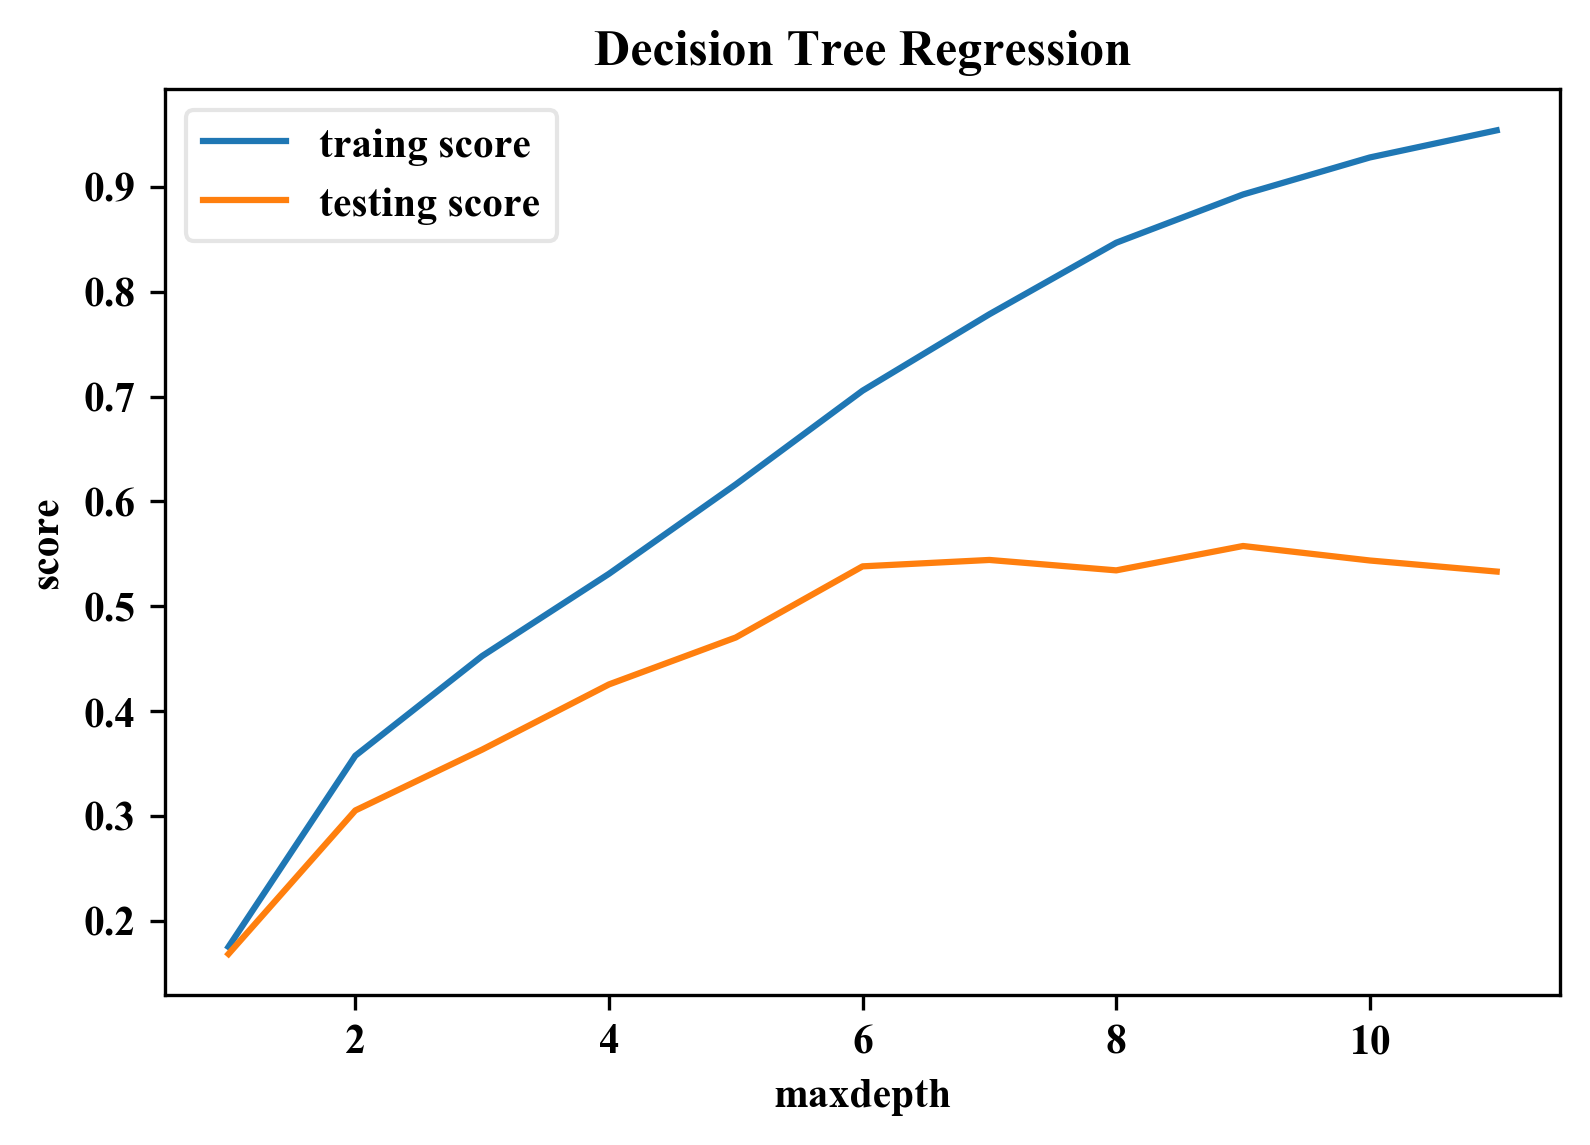

In [16]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.regression import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score

def test_DecisionTreeRegressor_depth(*data,maxdepth):
    X_train,X_test,y_train,y_test=data
    depths=np.arange(1,maxdepth)
    training_scores=[]
    testing_scores=[]
    for depth in depths:
        regr = DecisionTreeRegressor(max_depth=depth)
        regr.fit(X_train, y_train)
        training_scores.append(regr.score(X_train,y_train))
        testing_scores.append(regr.score(X_test,y_test))

    ## 绘图
    fig=plt.figure(dpi= 300)
    ax=fig.add_subplot(1,1,1)
    ax.plot(depths,training_scores,label="traing score")
    ax.plot(depths,testing_scores,label="testing score")
    ax.set_xlabel("maxdepth")
    ax.set_ylabel("score")
    ax.set_title("Decision Tree Regression")
    ax.legend(framealpha=0.5)
    plt.show()
       
test_DecisionTreeRegressor_depth(X_train,X_test,y_train,y_test,maxdepth=12)

1789
767
MSE train: 612.691,test:969.625
24.752600121538862 31.138804286641314


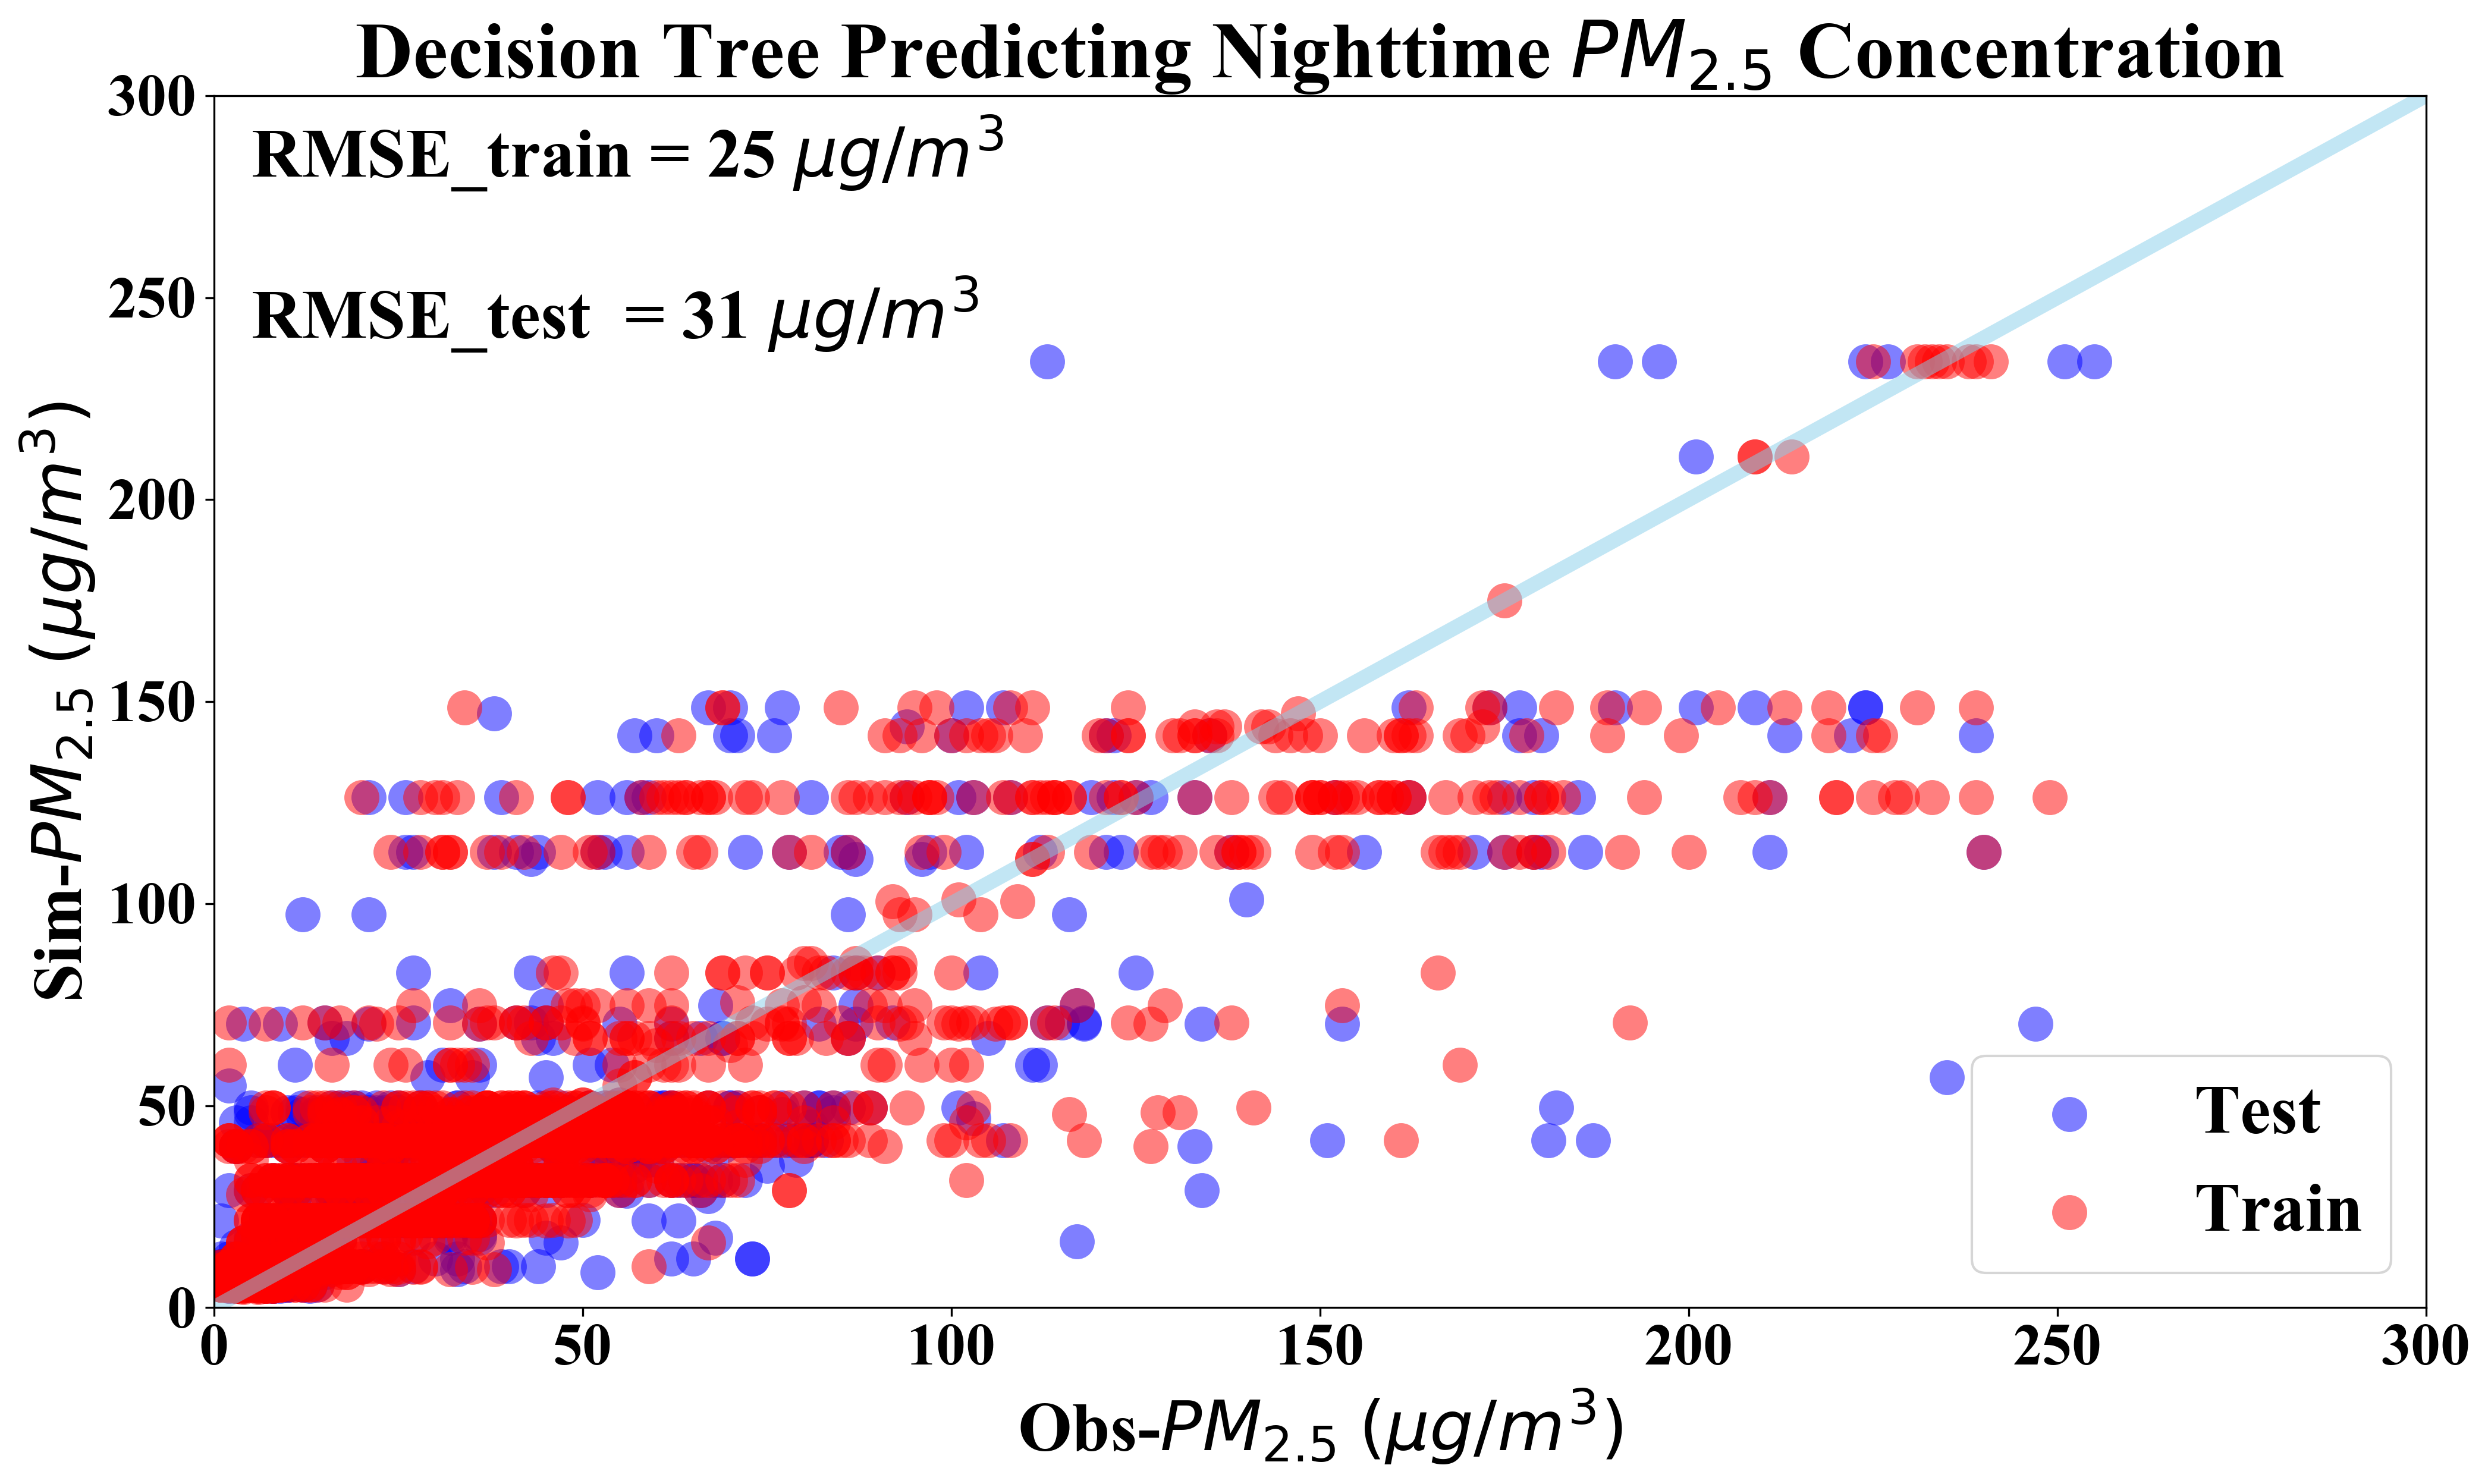

In [17]:
#X_train,X_test, y_train, y_test = train_test_split(X, y, random_state=36)

print(len(y_train))
print(len(y_test))
regr = DecisionTreeRegressor(max_depth=6)
regr.fit(X_train, y_train)
y = regr.predict(X_test)
y_train_pred=regr.predict(X_train)
y_pred = regr.predict(X_test)
from sklearn import metrics
print ('MSE train: %.3f,test:%.3f' % (mean_squared_error(y_train,y_train_pred),mean_squared_error(y_test,y_pred)))
#评估决定系数(coefficient of determination)，是MSE的标准化
#print ('R^2 train: %.3f,test:%.3f' % (r2_score(y_train,y_train_pred),r2_score(y_test,y_pred)))
RMSE_train=math.sqrt(mean_squared_error(y_train,y_train_pred))
RMSE_test=math.sqrt(mean_squared_error(y_test,y_pred))
#MSE_test_A=mean_squared_error(y_test,y_pred)
#R2_train_A=r2_score(y_train,y_train_pred)
R2_test_A=r2_score(y_test,y_pred)
print(RMSE_train,RMSE_test)
fig = plt.figure(figsize=(16,9),dpi= 300)
plt.subplot(111)
plt.tick_params(labelsize=24)
#plt.plot(Time,PMC_sim,c='blue',marker = 'o',linewidth=3,alpha=0.5,label="Simulation")
#plt.plot(Time,PMC_obs,c='red', marker = 'o',linewidth=3,alpha=0.5,label="Observation")
plt.scatter(y_test,y_pred,c='blue',s=200,marker = 'o',linewidth=0,alpha=0.5,label="Test")
plt.scatter(y_train,y_train_pred,c='red',s=200,marker = 'o',linewidth=0,alpha=0.5,label="Train")
x = np.arange(0, 400, 0.1)
y=x
plt.plot(x, y,c='skyblue',alpha=0.5,linewidth=6)
plt.ylim(0,300)
plt.xlim(0,300)
#plt.legend(loc="upper right",fontsize=28) #显示图中的标签
plt.xlabel('Obs-$PM_{2.5}$'+ ' '+'$ (µg/m^3)$',fontsize=28)
plt.ylabel('Sim-$PM_{2.5}$'+ ' '+'$ (µg/m^3)$',fontsize=28)
plt.legend(loc="lower right",fontsize=28)
titlestr='Decision Tree Predicting Nighttime $PM_{2.5}$ Concentration'
plt.title(titlestr,fontsize=32)
#plt.text(5,175,'Training set of model',fontsize=32)
plt.text(5,280,'RMSE_train = 25 $ µg/m^3$',fontsize=28)
plt.text(5,240,'RMSE_test  = 31 $ µg/m^3$',fontsize=28)
#plt.text(5,290,'Train Set = 4779 samples',fontsize=28)
#plt.text(5,260,'Test Set  = 1594 samples',fontsize=28)
plt.savefig(str(titlestr)+'.png')
plt.show()

In [18]:
import pydotplus
from sklearn import tree
xname=x_cols

dot_data = tree.export_graphviz(regr, out_file=None,filled=True,rounded=True,special_characters=True,feature_names=xname) 
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_pdf("Decision_Tree_Nighttime.pdf")

True

### 2. Multi-Layer Perceptron (MLP)

In [19]:
df.drop(['Time'], axis=1, inplace=True)
dfn=df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

254.0
2000 556 12 1
Epoch: 0001 cost= 0.007300463
Epoch: 0002 cost= 0.006732852
Epoch: 0003 cost= 0.006270556
Epoch: 0004 cost= 0.005898076
Epoch: 0005 cost= 0.005600713
Epoch: 0006 cost= 0.005367190
Epoch: 0007 cost= 0.005186706
Epoch: 0008 cost= 0.005044324
Epoch: 0009 cost= 0.004934326
Epoch: 0010 cost= 0.004850526
Epoch: 0011 cost= 0.004776483
Epoch: 0012 cost= 0.004711875
Epoch: 0013 cost= 0.004655722
Epoch: 0014 cost= 0.004607364
Epoch: 0015 cost= 0.004566418
Epoch: 0016 cost= 0.004531866
Epoch: 0017 cost= 0.004502674
Epoch: 0018 cost= 0.004478030
Epoch: 0019 cost= 0.004457862
Epoch: 0020 cost= 0.004441251
Epoch: 0021 cost= 0.004427529
Epoch: 0022 cost= 0.004415758
Epoch: 0023 cost= 0.004405456
Epoch: 0024 cost= 0.004396441
Epoch: 0025 cost= 0.004388572
Epoch: 0026 cost= 0.004381524
Epoch: 0027 cost= 0.004375204
Epoch: 0028 cost= 0.004369046
Epoch: 0029 cost= 0.004363120
Epoch: 0030 cost= 0.004357589
Training cost= 0.017416505
Test cost= 0.025820857
6.558497656136751 (µg/m^3)


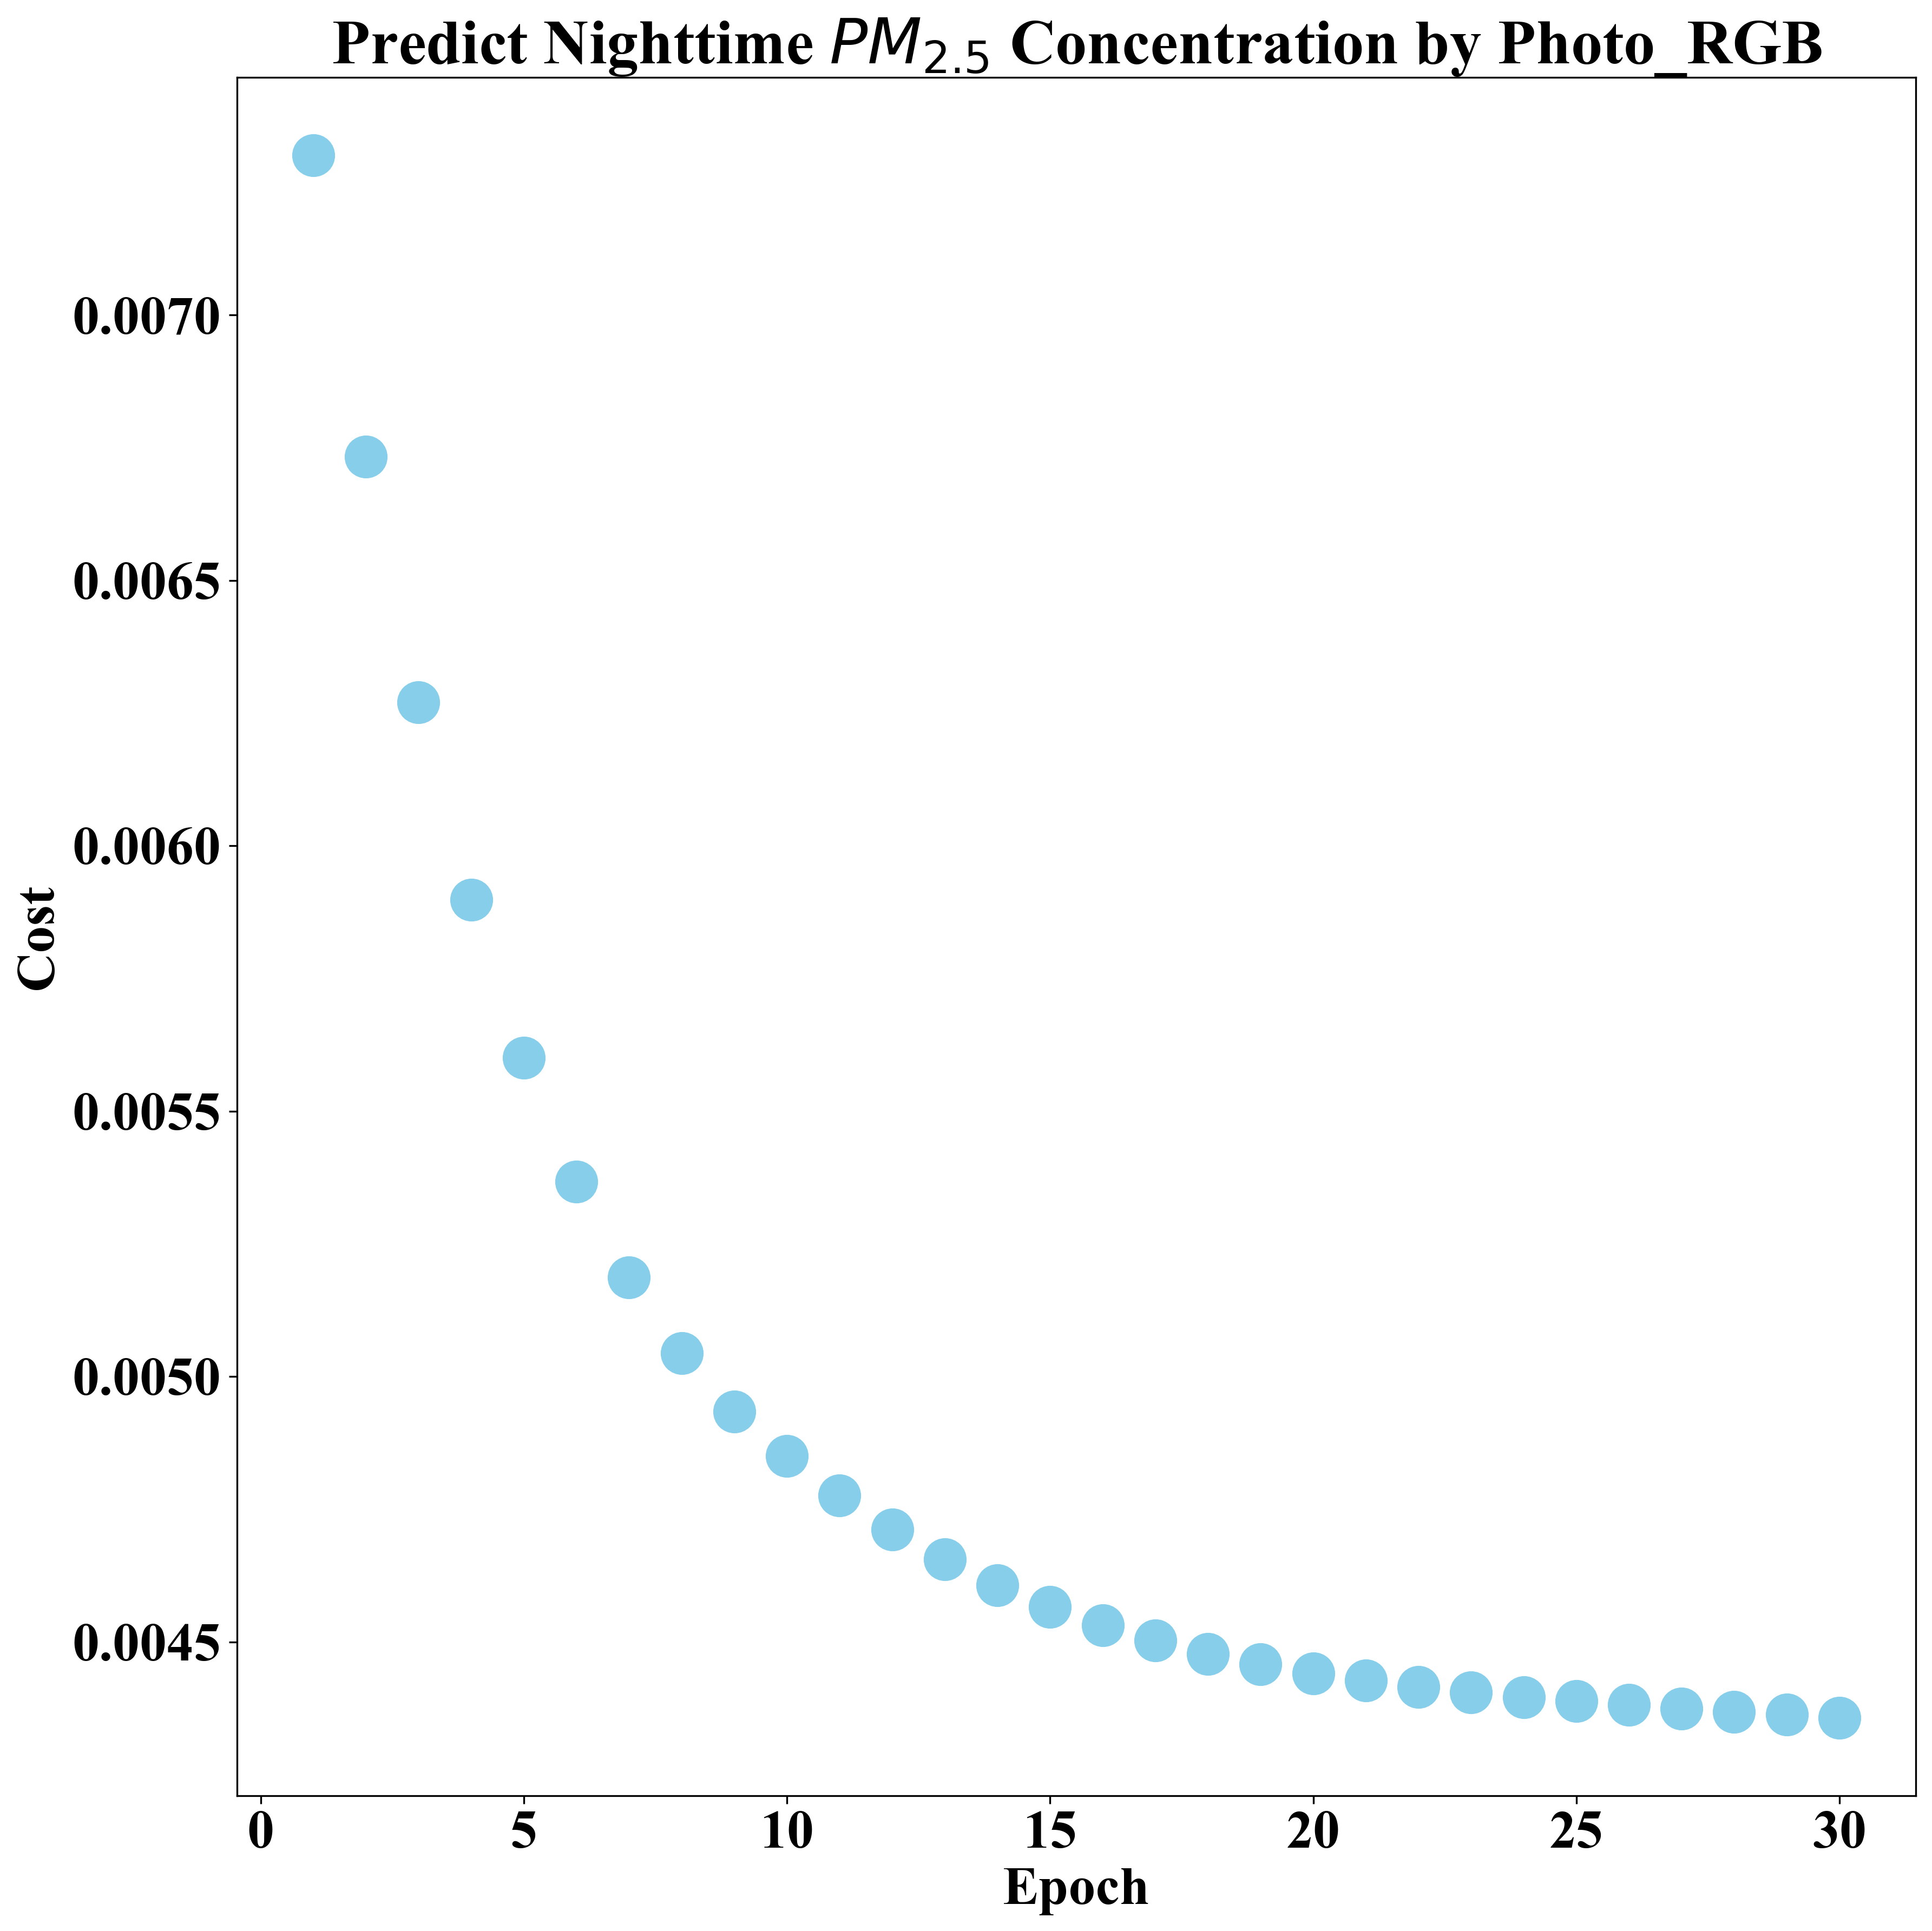

In [22]:
# 以下只需修改训练集和测试集
################################################################
X=dfn[x_cols]
y=dfn[y_cols]

X_train,y_train=X[0:2000].values,y[0:2000].values
X_test, y_test =X[2000:].values,y[2000:].values

Y_range=df['PM2.5'].max()-df['PM2.5'].min()
print(Y_range)
################################################################
import tensorflow as tf

SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)

tf.reset_default_graph()

n_samples = X_train.shape[0]# 行数，10000个小时
n_samples1 = X_test.shape[0]

# 设置模型参数

learning_rate = 0.001 #0.001是极限
training_epochs = 30 #
batch_size = 500
display_step = 1

# 三个隐藏层
n_hidden_1 = 3
n_hidden_2 = 3
n_hidden_3 = 3

n_input = X_train.shape[1]# 列数，占位用
n_output= y_train.shape[1]# 列数，占位用

print(n_samples,n_samples1,n_input,n_output)

# 占位符
x = tf.placeholder('float', [None, n_input])
y = tf.placeholder('float', [None, n_output])

def multiplayer_perceptron(x, weight, bias):

    layer1 = tf.add(tf.matmul(x, weight['h1']), bias['h1'])
    layer1 = tf.nn.relu(layer1)
    layer2 = tf.add(tf.matmul(layer1, weight['h2']), bias['h2'])
    layer2 = tf.nn.relu(layer2)
    layer3 = tf.add(tf.matmul(layer2, weight['h3']), bias['h3'])
    layer3 = tf.nn.relu(layer3)
    out_layer = tf.add(tf.matmul(layer3, weight['out']), bias['out'])

    return out_layer

weight = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])), 
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])), 
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_output]))
}

bias = {
    'h1': tf.Variable(tf.random_normal([n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_2])), 
    'h3': tf.Variable(tf.random_normal([n_hidden_3])), 
    'out': tf.Variable(tf.random_normal([n_output]))
}

# 建立模型
pred = multiplayer_perceptron(x, weight, bias)

# 定义损失函数
cost = tf.reduce_sum(tf.pow(pred-y, 2)) / ( n_samples) # MSE对于回归问题
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))# old_version
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))#对于分类问题

# 定义优化器：Adam算法
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# 初始化所有变量
init = tf.initialize_all_variables()

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

# 训练模型
fig, ax = plt.subplots(1,1,figsize=(12,12), dpi= 300)
plt.tick_params(labelsize=24)

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(training_epochs):
        avg_cost = 0
        total_batch = int(n_samples / batch_size)

        for i in range(total_batch):
            # run optimization op(backprop) and cost op(to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: X_train[i*batch_size : (i+1)*batch_size, :], 
                                                          y: y_train[i*batch_size : (i+1)*batch_size, :]})
            avg_cost += c / total_batch
            
        
        plt.plot(epoch+1, avg_cost, color='skyblue', marker='o', linestyle='solid',linewidth=2, markersize=18)

        if epoch % display_step == 0:
            print('Epoch:', '%04d' % (epoch+1), 'cost=', '{:.9f}'.format(avg_cost))

    #print('Opitimization Finished!')

    # 精确度
    # acc = accuracy.eval({x: X_test, y: y_test})
    # print('Accuracy:', acc)
    
    # logistics回归损失
    #from sklearn.metrics import log_loss
    # 创建会话
    #session = tf.Session()
    # 张量转化为ndarray
    #Y_test_n = session.run(y_test)
    #Y_n = session.run(y)
    #logistics_loss=log_loss(Y_test_n, Y_n)
    #print("Logistics cost=",logistics)
    
    # Tensorflow自带MSE
    training_cost = sess.run(cost, feed_dict={x: X_train, y: y_train})
    print("Training cost=", training_cost)
   
    test_cost = sess.run(cost, feed_dict={x: X_test, y: y_test})
    print("Test cost=", test_cost)
    
    real_lost=test_cost*Y_range
    #real_lost=test_cost
    print(real_lost,'(µg/m^3)')
    #print(real_lost,' m')
    
    plt.xlabel('Epoch',fontsize=24)
    plt.ylabel('Cost',fontsize=24)
    #plt.title('lr=%.3f, te=%d, bs=%d, acc=%.2f' % (learning_rate, training_epochs, batch_size, acc),fontsize=24)
    plt.title('Predict Nighttime '+'$PM_{2.5}$'+' Concentration by Photo_RGB',fontsize=28)
    plt.tight_layout()
    plt.savefig('MLP_test.png', dpi=300)

    #plt.show()